# Training Sequence

Dataset: 90 samples | Train: 62 | Val: 18 | Test: 10

=== DETAILED MASK INSPECTION ===
Sample 0:
  Shape: (256, 256)
  Dtype: int64
  Classes: [0 1 2 3 4]
  Class counts: [ 3257  1069  5389  1665 54156]
  Min/Max: 0/4
  Class 0: 3257 pixels (5.0%)
  Class 1: 1069 pixels (1.6%)
  Class 2: 5389 pixels (8.2%)
  Class 3: 1665 pixels (2.5%)
  Class 4: 54156 pixels (82.6%)

Sample 1:
  Shape: (256, 256)
  Dtype: int64
  Classes: [0 1 2 3 4]
  Class counts: [ 4761  1074  4850  1609 53242]
  Min/Max: 0/4
  Class 0: 4761 pixels (7.3%)
  Class 1: 1074 pixels (1.6%)
  Class 2: 4850 pixels (7.4%)
  Class 3: 1609 pixels (2.5%)
  Class 4: 53242 pixels (81.2%)

Sample 2:
  Shape: (256, 256)
  Dtype: int64
  Classes: [0 1 2 3 4]
  Class counts: [ 3786  1074  5302  1659 53715]
  Min/Max: 0/4
  Class 0: 3786 pixels (5.8%)
  Class 1: 1074 pixels (1.6%)
  Class 2: 5302 pixels (8.1%)
  Class 3: 1659 pixels (2.5%)
  Class 4: 53715 pixels (82.0%)

Training Config:
  Device: cuda
  Model parameters: 31,043,78

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


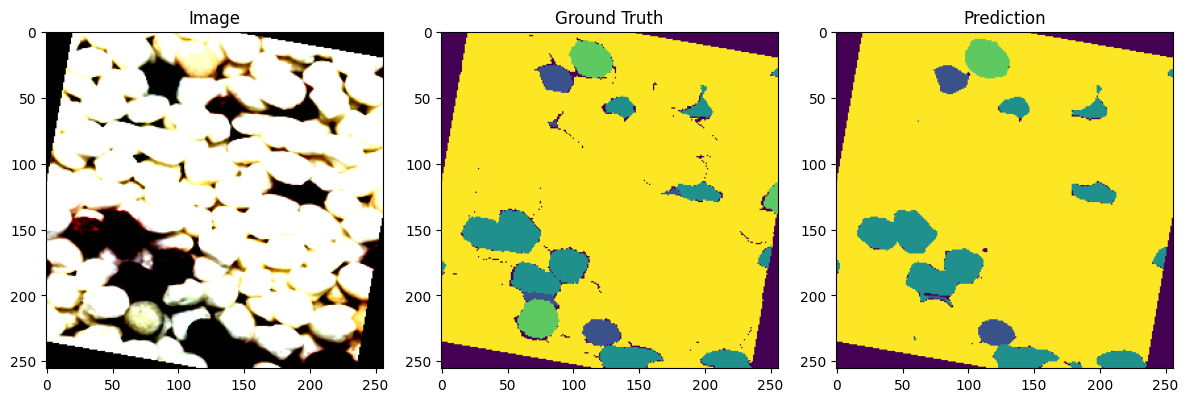

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import defaultdict
import time
import random

# Import your custom U-Net
from custom_unet import SimpleUNet, ConvBlock

# --- Joint transform class with debug ---
class JointTransform:
    def __init__(self, img_size=256):
        self.img_size = img_size
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.color_jitter = transforms.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.05
        )

    def __call__(self, image, mask):
        # Resize
        image = image.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)

        # Random horizontal flip
        if random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        # Random vertical flip
        if random.random() > 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Random rotation
        angle = random.uniform(-10, 10)
        image = image.rotate(angle, resample=Image.BILINEAR, fillcolor=(0, 0, 0))
        mask = mask.rotate(angle, resample=Image.NEAREST, fillcolor=0)

        # Random color jitter
        if random.random() > 0.5:
            image = self.color_jitter(image)

        # Convert to tensor and normalize image
        image = self.to_tensor(image)
        image = self.normalize(image)

        # Convert mask to tensor long
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


# --- Dataset with joint transform ---
class BeadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, joint_transform=None, debug=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.joint_transform = joint_transform
        self.debug = debug
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if self.debug:
            print(f"[BeadDataset] Found {len(self.images)} images in {image_dir}")
            print(f"[BeadDataset] First few images: {self.images[:3]}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_path = os.path.join(self.mask_dir, img_name)
        if not os.path.exists(mask_path):
            base_name = os.path.splitext(img_name)[0]
            for ext in ['.png', '.jpg', '.jpeg']:
                mask_path = os.path.join(self.mask_dir, base_name + ext)
                if os.path.exists(mask_path):
                    break
            else:
                raise FileNotFoundError(f"No mask found for image {img_name} in {self.mask_dir}")

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.debug and idx < 3:
            print(f"\n[BeadDataset DEBUG] Sample {idx}:")
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")
            print(f"Mask mode: {mask.mode}")
            mask_arr = np.array(mask)
            print(f"Mask shape: {mask_arr.shape}, dtype: {mask_arr.dtype}")
            print(f"Mask unique values: {np.unique(mask_arr)}")

        # Convert mask multi-channel to single if needed
        mask_array = np.array(mask)
        if len(mask_array.shape) > 2:
            mask_array = mask_array[:, :, 0]
            mask = Image.fromarray(mask_array.astype(np.uint8), mode='L')

        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)
        else:
            # No augmentation fallback
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])(image)
            mask = torch.from_numpy(np.array(mask)).long()

        if self.debug and idx < 3:
            print(f"[BeadDataset DEBUG] After transform:")
            print(f"Image tensor shape: {image.shape}, dtype: {image.dtype}")
            print(f"Mask tensor shape: {mask.shape}, dtype: {mask.dtype}")
            unique_mask = torch.unique(mask)
            print(f"Mask unique values: {unique_mask}")

        return image, mask


class DiceScore(nn.Module):
    """Dice coefficient for segmentation evaluation with debugging"""
    
    def __init__(self, num_classes, smooth=1e-6, debug=False):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.debug = debug
        self.call_count = 0
    
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice_scores = []
        
        # Debug first few calls
        if self.debug and self.call_count < 5:
            print(f"\n=== DICE DEBUG CALL {self.call_count} ===")
            print(f"Pred shape: {pred.shape}")
            print(f"Target shape: {target.shape}")
            print(f"Target unique values: {torch.unique(target)}")
            print(f"Target value counts: {torch.bincount(target.flatten())}")
            
            # Check prediction distribution
            pred_classes = torch.argmax(pred, dim=1)
            print(f"Predicted classes unique: {torch.unique(pred_classes)}")
            print(f"Predicted classes counts: {torch.bincount(pred_classes.flatten())}")
        
        for i in range(self.num_classes):
            pred_i = pred[:, i]
            target_i = (target == i).float()
            
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()
            
            dice = (2 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
            
            # Debug class-specific dice
            if self.debug and self.call_count < 5:
                print(f"Class {i}: intersection={intersection:.4f}, union={union:.4f}, dice={dice:.4f}")
        
        if self.debug and self.call_count < 5:
            print("=" * 30)
        
        self.call_count += 1
        return torch.stack(dice_scores).mean()


class SqueezeToLong:
    """Custom transform to replace lambda for multiprocessing compatibility"""
    def __call__(self, x):
        return x.squeeze().long()


class SegmentationTrainer:
    """Complete training pipeline for SimpleUNet with enhanced debugging"""
    
    def __init__(self, model, device, train_loader, val_loader, n_classes=4, debug=False):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_classes = n_classes
        self.debug = debug
        
        # Ensure model uses GPU efficiently
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            if torch.cuda.device_count() > 1:
                self.model = nn.DataParallel(self.model)
        
        # Loss functions
        self.criterion = nn.CrossEntropyLoss()
        self.dice_metric = DiceScore(n_classes, debug=debug)
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=1e-3, 
            weight_decay=1e-4
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5
        )
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'lr': []
        }
        
        # Best model tracking
        self.best_dice = 0.0
        self.best_model_state = None
        
        # Track scheduler events
        self.previous_lr = self.optimizer.param_groups[0]['lr']
    
    def debug_batch(self, data, target, output, batch_idx, phase="train"):
        """Debug a single batch"""
        if batch_idx == 0:  # Debug first batch only
            print(f"\n=== {phase.upper()} BATCH DEBUG ===")
            print(f"Input shape: {data.shape}")
            print(f"Target shape: {target.shape}")
            print(f"Output shape: {output.shape}")
            print(f"Target unique values: {torch.unique(target)}")
            print(f"Target value distribution: {torch.bincount(target.flatten())}")
            
            # Check model output
            pred_classes = torch.argmax(output, dim=1)
            print(f"Predicted classes unique: {torch.unique(pred_classes)}")
            print(f"Predicted classes distribution: {torch.bincount(pred_classes.flatten())}")
            
            # Check if model is predicting only one class
            pred_probs = F.softmax(output, dim=1)
            for i in range(self.n_classes):
                class_prob = pred_probs[:, i].mean()
                print(f"Class {i} avg probability: {class_prob:.4f}")
            
            print("=" * 40)
    
    def train_epoch(self):
        """Train for one epoch with debugging"""
        self.model.train() 
        running_loss = 0.0
        running_dice = 0.0
        
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            
            # Debug first batch
            if self.debug and batch_idx == 0:
                self.debug_batch(data, target, output, batch_idx, "train")
            
            # Calculate loss
            loss = self.criterion(output, target)
            dice = self.dice_metric(output, target)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            running_dice += dice.item()
        
        avg_loss = running_loss / len(self.train_loader)
        avg_dice = running_dice / len(self.train_loader)
        
        return avg_loss, avg_dice
    
    def validate(self):
        """Validate the model with debugging"""
        self.model.eval()
        running_loss = 0.0
        running_dice = 0.0
        
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(self.val_loader):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                
                # Debug first batch
                if self.debug and batch_idx == 0:
                    self.debug_batch(data, target, output, batch_idx, "val")
                
                loss = self.criterion(output, target)
                dice = self.dice_metric(output, target)
                
                running_loss += loss.item()
                running_dice += dice.item()
        
        avg_loss = running_loss / len(self.val_loader)
        avg_dice = running_dice / len(self.val_loader)
        
        return avg_loss, avg_dice
    
    def train(self, num_epochs, save_dir='checkpoints', print_every=1):
        """Full training loop with debugging for first 5 epochs only"""
        os.makedirs(save_dir, exist_ok=True)
        
        print(f"Training Config:")
        print(f"  Device: {self.device}")
        print(f"  Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"  Epochs: {num_epochs}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB" if torch.cuda.is_available() else "")
        print(f"  Classes: {self.n_classes}")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Enable debug only for first 5 epochs
            self.debug = (epoch < 5)
            self.dice_metric.debug = (epoch < 5)
            
            # Training phase
            train_loss, train_dice = self.train_epoch()
            
            # Validation phase
            val_loss, val_dice = self.validate()
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Check for LR reduction
            lr_reduced = current_lr != self.previous_lr
            if lr_reduced:
                self.previous_lr = current_lr
            
            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['lr'].append(current_lr)
            
            # Save best model
            is_best = val_dice > self.best_dice
            if is_best:
                self.best_dice = val_dice
                self.best_model_state = self.model.state_dict().copy()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_dice': self.best_dice,
                    'history': self.history
                }, os.path.join(save_dir, 'best_model.pth'))
            
            # Regular checkpoint every 100 epochs
            if (epoch + 1) % 100 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'history': self.history
                }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
            
            # Print summary every epoch (or you can keep print_every logic if preferred)
            epoch_time = time.time() - epoch_start
            status = ""
            if is_best:
                status += " [BEST]"
            if lr_reduced:
                status += f" [LR: {current_lr:.6f}]"
            
            print(f"Epoch {epoch+1:4d}/{num_epochs} | "
                f"Train L: {train_loss:.4f} D: {train_dice:.4f} | "
                f"Val L: {val_loss:.4f} D: {val_dice:.4f} | "
                f"Time: {epoch_time:.1f}s{status}")
        
        total_time = time.time() - start_time
        print("-" * 60)
        print(f"Training completed in {total_time/60:.1f} minutes")
        print(f"Best validation Dice: {self.best_dice:.4f}")
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print("Best model loaded.")

    
    def plot_training_history(self):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title('Loss Curves')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Dice curves
        axes[0, 1].plot(self.history['train_dice'], label='Train Dice')
        axes[0, 1].plot(self.history['val_dice'], label='Val Dice')
        axes[0, 1].set_title('Dice Score Curves')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Dice Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Learning rate
        axes[1, 0].plot(self.history['lr'])
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
        
        # Combined metrics
        axes[1, 1].plot(self.history['val_loss'], label='Val Loss', alpha=0.7)
        ax2 = axes[1, 1].twinx()
        ax2.plot(self.history['val_dice'], label='Val Dice', color='orange', alpha=0.7)
        axes[1, 1].set_title('Validation Metrics')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss', color='blue')
        ax2.set_ylabel('Dice Score', color='orange')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_loader):
        """Comprehensive model evaluation"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Evaluating'):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                pred = torch.argmax(output, dim=1)
                
                all_predictions.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions))
        
        # Confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return all_predictions, all_targets


class MaskToTensor:
    """Enhanced mask to tensor conversion with debugging"""
    def __init__(self, debug=False):
        self.debug = debug
        self.call_count = 0
    
    def __call__(self, pic):
        if self.debug and self.call_count < 3:
            print(f"\n=== MaskToTensor DEBUG {self.call_count} ===")
            pic_array = np.array(pic)
            print(f"Input type: {type(pic)}")
            print(f"Input shape: {pic_array.shape}")
            print(f"Input dtype: {pic_array.dtype}")
            print(f"Input min/max: {pic_array.min()}/{pic_array.max()}")
            print(f"Input unique: {np.unique(pic_array)}")
            
            result = torch.from_numpy(pic_array).long()
            print(f"Output shape: {result.shape}")
            print(f"Output dtype: {result.dtype}")
            print(f"Output min/max: {result.min()}/{result.max()}")
            print(f"Output unique: {torch.unique(result)}")
            print("=" * 30)
            
        self.call_count += 1
        return torch.from_numpy(np.array(pic)).long()


# --- Updated create_data_loaders with debug ---
def create_data_loaders(data_dir, batch_size=8, img_size=256,
                        train_ratio=0.7, val_ratio=0.2, test_ratio=0.1,
                        random_seed=42, debug=False):

    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must equal 1.0")

    random.seed(random_seed)

    train_joint_transform = JointTransform(img_size=img_size)

    # For val/test: simple resize + tensor + normalize (no augmentation)
    def val_test_transform(img, msk):
        img = img.resize((img_size, img_size), Image.BILINEAR)
        msk = msk.resize((img_size, img_size), Image.NEAREST)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])(img)
        msk = torch.from_numpy(np.array(msk)).long()
        return img, msk

    full_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=None,
        debug=debug
    )

    total_samples = len(full_dataset)

    indices = list(range(total_samples))
    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size

    train_indices, temp_indices = train_test_split(indices, train_size=train_size,
                                                  random_state=random_seed, shuffle=True)
    val_indices, test_indices = train_test_split(temp_indices, train_size=val_size,
                                                random_state=random_seed, shuffle=True)

    train_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=train_joint_transform,
        debug=debug
    )

    val_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=val_test_transform,
        debug=False
    )

    test_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=val_test_transform,
        debug=False
    )

    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)

    num_workers = 0
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    print(f"Dataset: {total_samples} samples | Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")

    return train_loader, val_loader, test_loader

def print_first_mask_classes(dataset):
    """Enhanced mask class inspection"""
    print("\n=== DETAILED MASK INSPECTION ===")
    
    # Check first 3 samples
    for i in range(min(3, len(dataset))):
        _, mask = dataset[i]
        
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = np.array(mask)
            
        unique_classes = np.unique(mask_np)
        class_counts = np.bincount(mask_np.flatten())
        
        print(f"Sample {i}:")
        print(f"  Shape: {mask_np.shape}")
        print(f"  Dtype: {mask_np.dtype}")
        print(f"  Classes: {unique_classes}")
        print(f"  Class counts: {class_counts}")
        print(f"  Min/Max: {mask_np.min()}/{mask_np.max()}")
        
        # Check class distribution
        total_pixels = mask_np.size
        for class_id in unique_classes:
            count = class_counts[class_id] if class_id < len(class_counts) else 0
            percentage = (count / total_pixels) * 100
            print(f"  Class {class_id}: {count} pixels ({percentage:.1f}%)")
        print()
    
    print("=" * 40)


def main():
    """Main training script with comprehensive debugging"""
    # Set device and optimize for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # GPU optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
    
    # Create model (you'll need to define SimpleUNet or import it)
    model = SimpleUNet(n_classes=5)
    
    # Create data loaders with debugging enabled
    train_loader, val_loader, test_loader = create_data_loaders(
        data_dir='UNET_dataset',
        batch_size=8,
        img_size=256,
        debug=False  # Enable debugging
    )
    
    # Enhanced mask inspection
    dataset_for_inspection = train_loader.dataset.dataset
    print_first_mask_classes(dataset_for_inspection)
    
    # Uncomment when you have the model defined
    trainer = SegmentationTrainer(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        n_classes=5,
        debug=False  # Enable debugging
    )
    
    trainer.train(num_epochs=200, print_every=5)  # Short debug run
    visualize_prediction(model, train_loader.dataset.dataset, device)

def visualize_prediction(model, dataset, device):
    model.eval()
    image, mask = dataset[0]
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
    ax[0].set_title('Image')
    ax[1].imshow(mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(pred)
    ax[2].set_title('Prediction')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# Simple usage

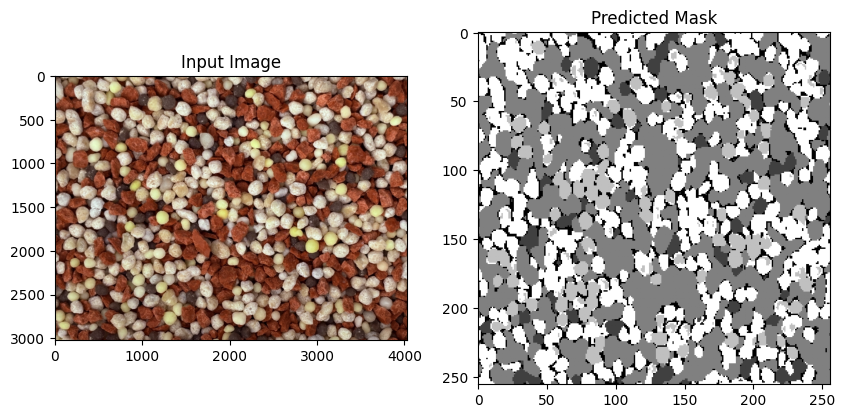

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from custom_unet import SimpleUNet, ConvBlock

NUM_CLASSES = 5

# Load checkpoint and extract weights
checkpoint = torch.load("checkpoints/best_model.pth", map_location='cuda')
model = SimpleUNet(in_channels=3, n_classes=5)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to('cuda')  # if you're using GPU


transform = transforms.Compose([
    transforms.Resize((256, 256)),  # must match training size
    transforms.ToTensor(),          # Converts to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # same normalization as training
])

img = Image.open("regressor_dataset/15-4-20/IMG_0869.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to('cuda')  # Add batch dimension

with torch.no_grad():
    output = model(input_tensor)  # Shape: [1, num_classes, H, W]

# If it's binary segmentation
if output.shape[1] == 1:
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
else:
    pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')  # or a colormap if multiclass
plt.show()


# Detailed Visualization 

C:\Users\Admins\AppData\Local\Temp\ipykernel_21176\4054571234.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap(colormap)(class_idx)


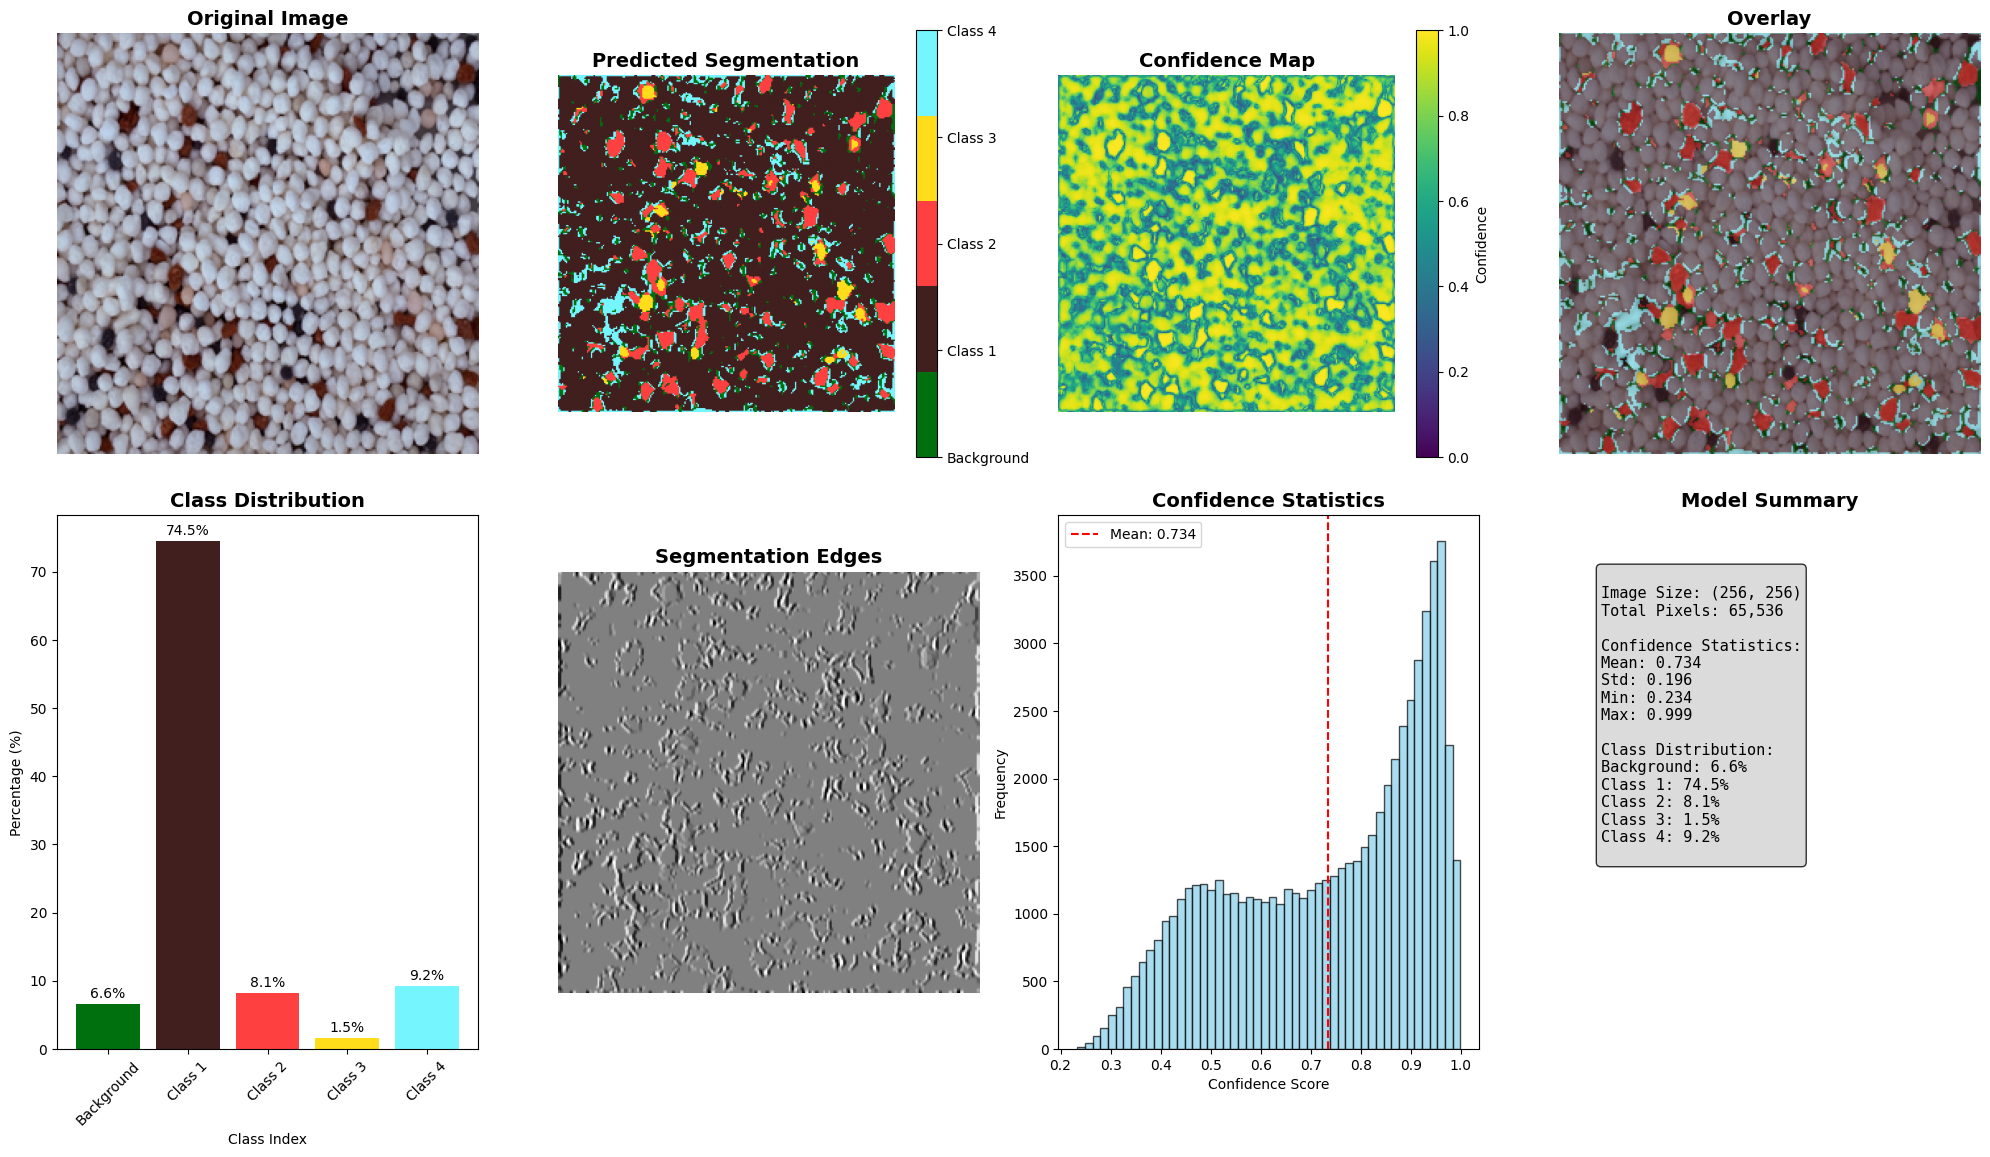

In [11]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from custom_unet import SimpleUNet, ConvBlock

NUM_CLASSES = 5
TRANSPARENCY = 0.5

# Define class names and colors for better visualization
CLASS_NAMES = ['Background', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
# Create a distinct color palette for each class
COLORS = ["#00700F", "#411F1F", "#FF4040", "#FFDD1A", "#75F6FF"]
colormap = ListedColormap(COLORS[:NUM_CLASSES])

# Load checkpoint and extract weights
checkpoint = torch.load("checkpoints/best_model.pth", map_location='cuda')
model = SimpleUNet(in_channels=3, n_classes=5)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to('cuda')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
img = Image.open("regressor_dataset/18-4-5/IMG_0839.JPG").convert("RGB")
img = img.resize((256, 256))  # ✅ match model input size for correct overlay
input_tensor = transform(img).unsqueeze(0).to('cuda')

# Get model prediction
with torch.no_grad():
    output = model(input_tensor)

# Process output based on segmentation type
if output.shape[1] == 1:
    # Binary segmentation
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
    confidence_map = pred_mask
else:
    # Multi-class segmentation
    softmax_output = torch.softmax(output, dim=1)
    pred_mask_binary = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    confidence_map = torch.max(softmax_output, dim=1)[0].squeeze().cpu().numpy()

# Create enhanced visualization
fig = plt.figure(figsize=(20, 12))

# Original image
plt.subplot(2, 4, 1)
plt.title("Original Image", fontsize=14, fontweight='bold')
plt.imshow(img)
plt.axis('off')

# Predicted mask with colors
plt.subplot(2, 4, 2)
plt.title("Predicted Segmentation", fontsize=14, fontweight='bold')
plt.imshow(pred_mask_binary, cmap=colormap, vmin=0, vmax=NUM_CLASSES-1)
plt.axis('off')

# Add colorbar for class reference
cbar = plt.colorbar(shrink=0.8)
cbar.set_ticks(range(NUM_CLASSES))
cbar.set_ticklabels(CLASS_NAMES)

# Confidence/probability map
plt.subplot(2, 4, 3)
plt.title("Confidence Map", fontsize=14, fontweight='bold')
plt.imshow(confidence_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(shrink=0.8, label='Confidence')
plt.axis('off')

# Overlay prediction on original image
plt.subplot(2, 4, 4)
plt.title("Overlay", fontsize=14, fontweight='bold')
plt.imshow(img)
# Create a mask overlay with transparency
overlay = np.zeros((*pred_mask_binary.shape, 4))
for class_idx in range(NUM_CLASSES):
    mask = pred_mask_binary == class_idx
    if np.any(mask):
        color = plt.cm.get_cmap(colormap)(class_idx)
        overlay[mask] = [color[0], color[1], color[2], TRANSPARENCY]  # 50% transparency
plt.imshow(overlay)
plt.axis('off')

# Class distribution histogram
plt.subplot(2, 4, 5)
unique, counts = np.unique(pred_mask_binary, return_counts=True)
class_percentages = counts / pred_mask_binary.size * 100
bars = plt.bar(unique, class_percentages, color=[COLORS[i] for i in unique])
plt.title("Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class Index")
plt.ylabel("Percentage (%)")
plt.xticks(unique, [CLASS_NAMES[i] for i in unique], rotation=45)
# Add percentage labels on bars
for bar, percentage in zip(bars, class_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

# Edge detection visualization
plt.subplot(2, 4, 6)
plt.title("Segmentation Edges", fontsize=14, fontweight='bold')
from scipy import ndimage
edges = ndimage.sobel(pred_mask_binary.astype(float))
plt.imshow(edges, cmap='gray')
plt.axis('off')

# Model confidence statistics
plt.subplot(2, 4, 7)
plt.title("Confidence Statistics", fontsize=14, fontweight='bold')
plt.hist(confidence_map.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.axvline(confidence_map.mean(), color='red', linestyle='--', 
            label=f'Mean: {confidence_map.mean():.3f}')
plt.legend()

# Summary statistics text
plt.subplot(2, 4, 8)
plt.title("Model Summary", fontsize=14, fontweight='bold')
plt.axis('off')

# Calculate summary statistics
total_pixels = pred_mask_binary.size
mean_confidence = confidence_map.mean()
std_confidence = confidence_map.std()
min_confidence = confidence_map.min()
max_confidence = confidence_map.max()

summary_text = f"""
Image Size: {img.size}
Total Pixels: {total_pixels:,}

Confidence Statistics:
Mean: {mean_confidence:.3f}
Std: {std_confidence:.3f}
Min: {min_confidence:.3f}
Max: {max_confidence:.3f}

Class Distribution:
"""

for i, (class_idx, count) in enumerate(zip(unique, counts)):
    percentage = count / total_pixels * 100
    summary_text += f"{CLASS_NAMES[class_idx]}: {percentage:.1f}%\n"

plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=11, fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))

plt.tight_layout()
plt.show()

# Optional: Save individual class masks
# print("\nSaving individual class masks...")
# for class_idx in range(NUM_CLASSES):
#     class_mask = (pred_mask_binary == class_idx).astype(np.uint8) * 255
#     class_img = Image.fromarray(class_mask, mode='L')
#     class_img.save(f"class_{class_idx}_{CLASS_NAMES[class_idx]}_mask.png")
#     print(f"Saved: class_{class_idx}_{CLASS_NAMES[class_idx]}_mask.png")

# print(f"\nVisualization complete! Image processed with {NUM_CLASSES} classes.")
# print(f"Average model confidence: {mean_confidence:.3f}")